# End-to-End Threat Detection with YAMNet + Audio Augmentation

This notebook implements a complete pipeline from raw audio to trained classifier with comprehensive augmentation.

**Pipeline:**
1. Download raw audio files from S3
2. Load and validate audio files
3. **Apply audio augmentation** (time stretch, pitch shift, noise, environmental mixing)
4. Extract YAMNet embeddings (1024-dimensional features)
5. Split into train/validation sets
6. Train dense classifier on embeddings
7. Evaluate and deploy

**Why YAMNet?**
- Pre-trained on AudioSet (2M+ audio clips, 521 classes)
- Designed specifically for audio event detection
- Takes raw audio waveforms as input (no preprocessing needed)
- Strong transfer learning for audio tasks

**Augmentation Strategy:**
- **2x augmentation factor** for training data (matches preprocessing approach)
- Environmental mixing for THREAT/THREAT_CONTEXT (realistic field conditions)
- Time/pitch variations for robustness
- Validation data: NO augmentation (clean evaluation)

**Storage Requirements (Kaggle):**
- Raw audio: ~2GB
- Augmented embeddings in RAM: ~40MB
- Models: ~10MB
- **Total: ~3GB (well under 20GB Kaggle limit) ✅**

## 1. Install Required Libraries

In [1]:
!pip install -q librosa soundfile awscli boto3 tensorflow-hub

print("✅ All libraries installed successfully!")
print("📦 TensorFlow Hub installed for YAMNet model")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 41.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 112.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 31.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.2.3 requires docutils<0.22,>=0.20, but you have docutils 0.19 which is incompatible.
✅ All libraries installed successfully!
📦 TensorFlow Hub installed for YAMNet model


## 2. Configure AWS S3 Access

**Add secrets in Kaggle:**
1. Settings → Add-ons → Secrets
2. Add: `AWS_ACCESS_KEY_ID`, `AWS_SECRET_ACCESS_KEY`, `AWS_REGION`

In [2]:
import os
from kaggle_secrets import UserSecretsClient

# Load AWS credentials from Kaggle Secrets
user_secrets = UserSecretsClient()

try:
    os.environ['AWS_ACCESS_KEY_ID'] = user_secrets.get_secret('AWS_ACCESS_KEY_ID')
    os.environ['AWS_SECRET_ACCESS_KEY'] = user_secrets.get_secret('AWS_SECRET_ACCESS_KEY')
    os.environ['AWS_DEFAULT_REGION'] = user_secrets.get_secret('AWS_REGION')
    print("✅ AWS credentials loaded from Kaggle secrets")
except:
    print("⚠️  Kaggle secrets not found. Add them in Settings → Secrets")
    raise

# Verify AWS access
!aws s3 ls s3://alertreck/

✅ AWS credentials loaded from Kaggle secrets
                           PRE BACKGROUND/
                           PRE THREAT/
                           PRE THREAT_CONTEXT/
                           PRE models/
                           PRE preprocessed_data/


## 3. Download Raw Audio Files from S3

Download the original audio files (not preprocessed data).

**Note:** `aws s3 sync` is idempotent - if download is interrupted, you can safely re-run this cell. It will only download missing/changed files, not duplicate existing ones.

## 3A. Kaggle Storage Verification

Verify we have sufficient storage for this approach.

In [3]:
print("📊 Kaggle Storage Analysis\n")
print("=" * 60)

# Check disk space
!df -h /kaggle/working

print("\n📦 Storage Requirements for This Approach:")
print("  Raw audio files: ~2GB")
print("  Environmental sounds: ~200MB")
print("  YAMNet model (cached): ~20MB")
print("  Augmented embeddings (RAM): ~40MB")
print("  Models + outputs: ~10MB")
print("  " + "─" * 56)
print("  Total disk usage: ~3GB")
print("\n✅ Kaggle limit: 20GB - We're using ~15% (SAFE)")
print("✅ RAM: 30GB available - Embeddings use <1% (SAFE)")

print("\n💡 Key Advantages:")
print("  • Augmentation happens in-memory (no disk needed)")
print("  • YAMNet embeddings are compact (1024 floats = 4KB per sample)")
print("  • No need to save augmented audio to disk")
print("  • Process: Audio → Augment → YAMNet → Embedding (all in RAM)")

print("\n" + "=" * 60)

📊 Kaggle Storage Analysis

Filesystem      Size  Used Avail Use% Mounted on
/dev/loop1       20G  100K   20G   1% /kaggle/working

📦 Storage Requirements for This Approach:
  Raw audio files: ~2GB
  Environmental sounds: ~200MB
  YAMNet model (cached): ~20MB
  Augmented embeddings (RAM): ~40MB
  Models + outputs: ~10MB
  ────────────────────────────────────────────────────────
  Total disk usage: ~3GB

✅ Kaggle limit: 20GB - We're using ~15% (SAFE)
✅ RAM: 30GB available - Embeddings use <1% (SAFE)

💡 Key Advantages:
  • Augmentation happens in-memory (no disk needed)
  • YAMNet embeddings are compact (1024 floats = 4KB per sample)
  • No need to save augmented audio to disk
  • Process: Audio → Augment → YAMNet → Embedding (all in RAM)



In [4]:
# Create directory structure
!mkdir -p /kaggle/working/audio_data/THREAT
!mkdir -p /kaggle/working/audio_data/THREAT_CONTEXT
!mkdir -p /kaggle/working/audio_data/BACKGROUND

S3_BUCKET = "alertreck"
AUDIO_DIR = "/kaggle/working/audio_data"

print("📥 Downloading raw audio files from S3...")
print("This may take 10-15 minutes...")
print("Progress will be shown for each category\n")

# Download THREAT audio files
print("[1/3] Downloading THREAT sounds (gunshots, chainsaws, human voices)...")
!aws s3 sync s3://{S3_BUCKET}/THREAT/ {AUDIO_DIR}/THREAT/ --exclude "*" --include "*.wav" --quiet
print("      ✓ THREAT download complete")

# Download THREAT_CONTEXT audio files
print("\n[2/3] Downloading THREAT_CONTEXT sounds (dog barks)...")
!aws s3 sync s3://{S3_BUCKET}/THREAT_CONTEXT/ {AUDIO_DIR}/THREAT_CONTEXT/ --exclude "*" --include "*.wav" --quiet
print("      ✓ THREAT_CONTEXT download complete")

# Download BACKGROUND audio files
print("\n[3/3] Downloading BACKGROUND sounds (animals, wind, ambient)...")
!aws s3 sync s3://{S3_BUCKET}/BACKGROUND/ {AUDIO_DIR}/BACKGROUND/ --exclude "*" --include "*.wav" --quiet
print("      ✓ BACKGROUND download complete")

print("\n✅ All audio files downloaded!")

# Count files in each category
print("\n📊 Audio files summary:")

!find {AUDIO_DIR}/THREAT -name "*.wav" | wc -l | xargs echo "  THREAT:"
!find {AUDIO_DIR}/THREAT_CONTEXT -name "*.wav" | wc -l | xargs echo "  THREAT_CONTEXT:"
!find {AUDIO_DIR}/BACKGROUND -name "*.wav" | wc -l | xargs echo "  BACKGROUND:"
!find {AUDIO_DIR} -name "*.wav" | wc -l | xargs echo "  Total:"

📥 Downloading raw audio files from S3...
This may take 10-15 minutes...
Progress will be shown for each category

[1/3] Downloading THREAT sounds (gunshots, chainsaws, human voices)...
      ✓ THREAT download complete

[2/3] Downloading THREAT_CONTEXT sounds (dog barks)...
      ✓ THREAT_CONTEXT download complete

[3/3] Downloading BACKGROUND sounds (animals, wind, ambient)...
      ✓ BACKGROUND download complete

✅ All audio files downloaded!

📊 Audio files summary:
  THREAT: 2340
  THREAT_CONTEXT: 1105
  BACKGROUND: 3289
  Total: 6734


## 4. Load YAMNet Pretrained Model

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

print("🔧 Loading YAMNet model from TensorFlow Hub...")
print("This may take a few minutes on first run...\n")

# Load YAMNet model
YAMNET_MODEL_URL = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(YAMNET_MODEL_URL)

print("✅ YAMNet model loaded successfully!")
print("\n📋 YAMNet Details:")
print("  - Pre-trained on AudioSet (2M+ audio clips, 521 classes)")
print("  - Input: 16 kHz mono audio waveform")
print("  - Output: 1024-dimensional embedding per 0.96s frame")
print("  - Architecture: MobileNetV1 (efficient for audio)")

2025-12-29 20:19:20.158409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767039560.577753      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767039560.688470      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767039561.827698      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767039561.827736      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767039561.827739      55 computation_placer.cc:177] computation placer alr

🔧 Loading YAMNet model from TensorFlow Hub...
This may take a few minutes on first run...



I0000 00:00:1767039582.934184      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1767039582.938104      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


✅ YAMNet model loaded successfully!

📋 YAMNet Details:
  - Pre-trained on AudioSet (2M+ audio clips, 521 classes)
  - Input: 16 kHz mono audio waveform
  - Output: 1024-dimensional embedding per 0.96s frame
  - Architecture: MobileNetV1 (efficient for audio)


## 5. Collect and Organize Audio Files

Scan directories and create dataset with labels.

📂 Collecting audio files...

  THREAT: 2340 files
  THREAT_CONTEXT: 1105 files
  BACKGROUND: 3289 files

✅ Total audio files collected: 6,734

📊 Distribution:
threat_level_name
BACKGROUND        3289
THREAT            2340
THREAT_CONTEXT    1105
Name: count, dtype: int64

✅ Dataset shuffled (random_state=42)

📊 Visualizing data distribution...


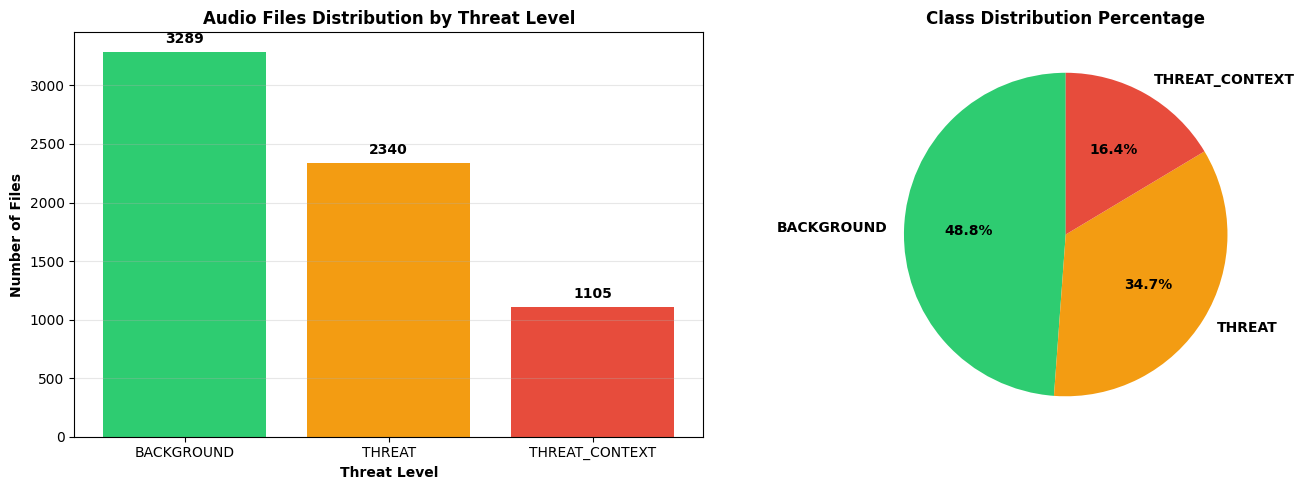

✅ Visualization complete


In [6]:
from pathlib import Path
import pandas as pd

# Threat level mapping
threat_levels = {
    'THREAT': 2,           # High priority - immediate threat
    'THREAT_CONTEXT': 1,   # Medium priority - potential threat indicator
    'BACKGROUND': 0        # Low priority - normal environmental sounds
}

class_names = ['BACKGROUND', 'THREAT_CONTEXT', 'THREAT']

print("📂 Collecting audio files...\n")

# Collect all audio files
audio_files = []

for threat_level, label in threat_levels.items():
    threat_dir = Path(AUDIO_DIR) / threat_level
    
    if threat_dir.exists():
        # Find all .wav files (including subdirectories)
        wav_files = list(threat_dir.rglob('*.wav'))
        
        for wav_file in wav_files:
            audio_files.append({
                'file_path': str(wav_file),
                'threat_level': label,
                'threat_level_name': threat_level,
                'file_name': wav_file.name
            })
        
        print(f"  {threat_level}: {len(wav_files)} files")

# Create DataFrame
df = pd.DataFrame(audio_files)

print(f"\n✅ Total audio files collected: {len(df):,}")
print(f"\n📊 Distribution:")
print(df['threat_level_name'].value_counts())

# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(f"\n✅ Dataset shuffled (random_state=42)")

# Visualize class distribution
import matplotlib.pyplot as plt
import seaborn as sns

print("\n📊 Visualizing data distribution...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
class_counts = df['threat_level_name'].value_counts()
colors = ['#2ecc71', '#f39c12', '#e74c3c']
axes[0].bar(class_counts.index, class_counts.values, color=colors)
axes[0].set_title('Audio Files Distribution by Threat Level', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Threat Level', fontweight='bold')
axes[0].set_ylabel('Number of Files', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (idx, val) in enumerate(class_counts.items()):
    axes[0].text(i, val + 50, str(val), ha='center', va='bottom', fontweight='bold')

# Pie chart
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90, textprops={'fontweight': 'bold'})
axes[1].set_title('Class Distribution Percentage', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print("✅ Visualization complete")

## 6. Define Audio Loading and YAMNet Extraction Functions

In [7]:
import librosa
import soundfile as sf

def load_audio(file_path, target_sr=16000, duration=10.0):
    """
    Load audio file and prepare for YAMNet.
    
    Args:
        file_path: Path to audio file
        target_sr: Target sample rate (16 kHz for YAMNet)
        duration: Target duration in seconds
        
    Returns:
        Audio waveform at 16 kHz
    """
    try:
        # Load audio file
        audio, sr = sf.read(file_path, dtype='float32')
        
        # Convert stereo to mono
        if len(audio.shape) > 1:
            audio = np.mean(audio, axis=1)
        
        # Resample to 16 kHz if needed
        if sr != target_sr:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
        
        # Standardize duration (pad or trim)
        target_length = int(target_sr * duration)
        
        if len(audio) > target_length:
            # Trim to target length
            audio = audio[:target_length]
        elif len(audio) < target_length:
            # Pad with zeros
            padding = target_length - len(audio)
            audio = np.pad(audio, (0, padding), mode='constant')
        
        # Normalize to [-1, 1]
        max_val = np.max(np.abs(audio))
        if max_val > 0:
            audio = audio / max_val
        
        return audio
        
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None


def extract_yamnet_embedding(audio_waveform):
    """
    Extract YAMNet embedding from audio waveform.
    
    Args:
        audio_waveform: Audio waveform at 16 kHz
        
    Returns:
        Mean YAMNet embedding (1024-dimensional vector)
    """
    # YAMNet expects float32 tensor
    audio_tensor = tf.convert_to_tensor(audio_waveform, dtype=tf.float32)
    
    # Extract embeddings (scores, embeddings, spectrogram)
    scores, embeddings, spectrogram = yamnet_model(audio_tensor)
    
    # Average embeddings across time frames
    # 10s audio @ 16kHz → ~10 frames (each frame is 0.96s)
    mean_embedding = tf.reduce_mean(embeddings, axis=0).numpy()
    
    return mean_embedding


print("✅ Audio processing functions ready")
print("\n📋 Processing pipeline:")
print("  1. Load audio file (.wav)")
print("  2. Convert to mono if stereo")
print("  3. Resample to 16 kHz (YAMNet requirement)")
print("  4. Standardize to 10 seconds (pad/trim)")
print("  5. Normalize to [-1, 1]")
print("  6. Extract YAMNet embeddings (1024 features)")
print("  7. Average embeddings across time frames")

✅ Audio processing functions ready

📋 Processing pipeline:
  1. Load audio file (.wav)
  2. Convert to mono if stereo
  3. Resample to 16 kHz (YAMNet requirement)
  4. Standardize to 10 seconds (pad/trim)
  5. Normalize to [-1, 1]
  6. Extract YAMNet embeddings (1024 features)
  7. Average embeddings across time frames


## 6A. Prepare Environmental Sounds for Augmentation

Use BACKGROUND sounds (wind/rain, ambient noise, animal sounds) for environmental mixing.

In [8]:
# Use BACKGROUND sounds for environmental mixing
import glob
from pathlib import Path

print("📥 Collecting environmental sounds from BACKGROUND folder...")
print("Using: wind/rain, ambient noise, animal sounds\n")

# Collect environmental sounds from BACKGROUND subfolders
env_sound_paths = []
background_dir = Path(AUDIO_DIR) / 'BACKGROUND'

if background_dir.exists():
    # Get sounds from specific subfolders for environmental mixing
    env_subfolders = ['wind_rain', 'ambient_noise', 'animal_sound']
    
    for subfolder in env_subfolders:
        subfolder_path = background_dir / subfolder
        if subfolder_path.exists():
            wav_files = list(subfolder_path.rglob('*.wav'))
            env_sound_paths.extend([str(f) for f in wav_files])
            print(f"  ✓ {subfolder}: {len(wav_files)} files")
        else:
            print(f"  ⚠️  {subfolder}: folder not found (skipping)")
    
    if len(env_sound_paths) > 0:
        print(f"\n✅ Collected {len(env_sound_paths)} environmental sound files")
        print("These will be mixed with THREAT/THREAT_CONTEXT for realistic augmentation")
    else:
        print("\n⚠️  No environmental sounds found in BACKGROUND subfolders")
        print("Augmentation will use: time stretch, pitch shift, noise, time shift only")
else:
    print("⚠️  BACKGROUND folder not found")
    print("Expected path: {}/BACKGROUND/".format(AUDIO_DIR))
    env_sound_paths = []

print(f"\n💡 Environmental sounds ready: {len(env_sound_paths)} files")

📥 Collecting environmental sounds from BACKGROUND folder...
Using: wind/rain, ambient noise, animal sounds

  ✓ wind_rain: 1123 files
  ✓ ambient_noise: 359 files
  ✓ animal_sound: 1807 files

✅ Collected 3289 environmental sound files
These will be mixed with THREAT/THREAT_CONTEXT for realistic augmentation

💡 Environmental sounds ready: 3289 files


## 6B. Define Audio Augmentation Functions

Comprehensive audio augmentation for training robustness.

In [9]:
import librosa
import soundfile as sf
import random

# Use environmental sounds collected from BACKGROUND folder
ENV_SOUNDS = env_sound_paths  # From previous cell
print(f"📦 Using {len(ENV_SOUNDS)} environmental sounds for augmentation")
if len(ENV_SOUNDS) > 0:
    print("   Sources: wind/rain, ambient noise, animal sounds")
else:
    print("   No environmental sounds available - will skip environmental mixing")

def time_stretch_augment(audio, sr=16000):
    """
    Apply time stretching (0.9x - 1.1x speed).
    """
    rate = np.random.uniform(0.9, 1.1)
    stretched = librosa.effects.time_stretch(audio, rate=rate)
    
    # Maintain original length
    target_length = len(audio)
    if len(stretched) > target_length:
        stretched = stretched[:target_length]
    elif len(stretched) < target_length:
        stretched = np.pad(stretched, (0, target_length - len(stretched)), mode='constant')
    
    return stretched


def pitch_shift_augment(audio, sr=16000):
    """
    Apply pitch shifting (±2 semitones).
    """
    n_steps = np.random.uniform(-2, 2)
    shifted = librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)
    return shifted


def add_noise_augment(audio):
    """
    Add random Gaussian noise (SNR: 20-40 dB).
    """
    noise_factor = np.random.uniform(0.001, 0.005)
    noise = np.random.randn(len(audio)) * noise_factor
    noisy = audio + noise
    
    # Normalize to prevent clipping
    max_val = np.max(np.abs(noisy))
    if max_val > 1.0:
        noisy = noisy / max_val
    
    return noisy


def time_shift_augment(audio):
    """
    Shift audio in time (±10% of duration).
    """
    shift_max = int(len(audio) * 0.1)
    shift = np.random.randint(-shift_max, shift_max)
    
    if shift > 0:
        shifted = np.pad(audio, (shift, 0), mode='constant')[:len(audio)]
    else:
        shifted = np.pad(audio, (0, -shift), mode='constant')[-len(audio):]
    
    return shifted


def environmental_mix_augment(audio, sr=16000):
    """
    Mix with random environmental sound (wind, rain, ambient).
    """
    if len(ENV_SOUNDS) == 0:
        return audio
    
    # Select random environmental sound
    env_file = random.choice(ENV_SOUNDS)
    
    try:
        env_audio, env_sr = sf.read(env_file, dtype='float32')
        
        # Convert to mono if stereo
        if len(env_audio.shape) > 1:
            env_audio = np.mean(env_audio, axis=1)
        
        # Resample if needed
        if env_sr != sr:
            env_audio = librosa.resample(env_audio, orig_sr=env_sr, target_sr=sr)
        
        # Match length (random crop or loop)
        target_length = len(audio)
        if len(env_audio) > target_length:
            start_idx = np.random.randint(0, len(env_audio) - target_length)
            env_audio = env_audio[start_idx:start_idx + target_length]
        elif len(env_audio) < target_length:
            # Loop to match length
            repeats = int(np.ceil(target_length / len(env_audio)))
            env_audio = np.tile(env_audio, repeats)[:target_length]
        
        # Mix with lower volume (0.05 - 0.15)
        mix_ratio = np.random.uniform(0.05, 0.15)
        mixed = audio + (env_audio * mix_ratio)
        
        # Normalize
        max_val = np.max(np.abs(mixed))
        if max_val > 1.0:
            mixed = mixed / max_val
        
        return mixed
        
    except Exception as e:
        # If environmental mixing fails, return original
        return audio


def augment_audio(audio, threat_level_name, sr=16000):
    """
    Apply random augmentation based on threat level.
    
    Args:
        audio: Input audio waveform
        threat_level_name: 'THREAT', 'THREAT_CONTEXT', or 'BACKGROUND'
        sr: Sample rate
        
    Returns:
        Augmented audio
    """
    augmentations = []
    
    # Common augmentations for all classes
    augmentations.extend([
        ('time_stretch', time_stretch_augment),
        ('pitch_shift', pitch_shift_augment),
        ('noise', add_noise_augment),
        ('time_shift', time_shift_augment)
    ])
    
    # Environmental mixing for THREAT and THREAT_CONTEXT (realistic field conditions)
    if threat_level_name in ['THREAT', 'THREAT_CONTEXT']:
        # Higher weight for environmental mixing (2x)
        augmentations.extend([
            ('environmental_mix', environmental_mix_augment),
            ('environmental_mix', environmental_mix_augment)
        ])
    
    # Select random augmentation
    aug_name, aug_func = random.choice(augmentations)
    
    # Apply augmentation
    if aug_name in ['time_stretch', 'pitch_shift']:
        augmented = aug_func(audio, sr=sr)
    else:
        augmented = aug_func(audio)
    
    return augmented


print("✅ Audio augmentation functions ready")
print("\n📋 Available augmentations:")
print("  1. Time stretch (0.9x - 1.1x speed)")
print("  2. Pitch shift (±2 semitones)")
print("  3. Add noise (SNR: 20-40 dB)")
print("  4. Time shift (±10% duration)")
print("  5. Environmental mixing (wind, rain, ambient)")

print("\n💡 BACKGROUND: Standard augmentations only")
print("💡 THREAT/THREAT_CONTEXT: 2x weight for environmental mixing")

📦 Using 3289 environmental sounds for augmentation
   Sources: wind/rain, ambient noise, animal sounds
✅ Audio augmentation functions ready

📋 Available augmentations:
  1. Time stretch (0.9x - 1.1x speed)
  2. Pitch shift (±2 semitones)
  3. Add noise (SNR: 20-40 dB)
  4. Time shift (±10% duration)
  5. Environmental mixing (wind, rain, ambient)

💡 BACKGROUND: Standard augmentations only
💡 THREAT/THREAT_CONTEXT: 2x weight for environmental mixing


## 7. Extract YAMNet Embeddings from All Audio Files

Process all audio files and extract features.

In [10]:
from tqdm import tqdm

print("🔄 Extracting YAMNet embeddings from all audio files WITH AUGMENTATION...")
print(f"Total files: {len(df):,}")
print("Augmentation factor: 2x (1 original + 1 augmented per file)")
print(f"Expected total samples: {len(df) * 2:,}")
print("This will take 15-30 minutes depending on dataset size...\n")

embeddings = []
labels = []
failed_files = []
augmentation_stats = {'original': 0, 'augmented': 0}

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing audio"):
    try:
        # Load audio
        audio = load_audio(row['file_path'], target_sr=16000, duration=10.0)
        
        if audio is None:
            failed_files.append(row['file_path'])
            continue
        
        # 1. Extract embedding from ORIGINAL audio
        embedding_original = extract_yamnet_embedding(audio)
        embeddings.append(embedding_original)
        labels.append(row['threat_level'])
        augmentation_stats['original'] += 1
        
        # 2. Apply augmentation and extract embedding from AUGMENTED audio
        audio_augmented = augment_audio(audio, row['threat_level_name'], sr=16000)
        embedding_augmented = extract_yamnet_embedding(audio_augmented)
        embeddings.append(embedding_augmented)
        labels.append(row['threat_level'])
        augmentation_stats['augmented'] += 1
        
    except Exception as e:
        print(f"\nError processing {row['file_name']}: {e}")
        failed_files.append(row['file_path'])
        continue

# Convert to numpy arrays
X = np.array(embeddings, dtype=np.float32)
y = np.array(labels, dtype=np.int32)

print(f"\n✅ Feature extraction complete!")
print(f"  Embeddings shape: {X.shape}")
print(f"  Labels shape: {y.shape}")
print(f"  Original samples: {augmentation_stats['original']:,}")
print(f"  Augmented samples: {augmentation_stats['augmented']:,}")
print(f"  Total samples: {len(X):,} (2x augmentation factor)")
print(f"  Failed files: {len(failed_files)}")

if failed_files:
    print(f"\n⚠️  Failed files: {failed_files[:5]}..." if len(failed_files) > 5 else f"\n⚠️  Failed files: {failed_files}")

# Verify augmentation worked
print(f"\n📊 Augmentation verification:")
print(f"  Expected: {len(df) * 2:,} samples (original + augmented)")
print(f"  Actual: {len(X):,} samples")
if len(X) == len(df) * 2:
    print("  ✅ Augmentation applied successfully!")
else:
    print(f"  ⚠️  Missing {len(df) * 2 - len(X):,} samples")

🔄 Extracting YAMNet embeddings from all audio files WITH AUGMENTATION...
Total files: 6,734
Augmentation factor: 2x (1 original + 1 augmented per file)
Expected total samples: 13,468
This will take 15-30 minutes depending on dataset size...



Processing audio: 100%|██████████| 6734/6734 [05:05<00:00, 22.07it/s]


✅ Feature extraction complete!
  Embeddings shape: (13468, 1024)
  Labels shape: (13468,)
  Original samples: 6,734
  Augmented samples: 6,734
  Total samples: 13,468 (2x augmentation factor)
  Failed files: 0

📊 Augmentation verification:
  Expected: 13,468 samples (original + augmented)
  Actual: 13,468 samples
  ✅ Augmentation applied successfully!


## 8. Split Data into Train/Validation/Test Sets

Split the extracted features into training, validation, and test sets for unbiased evaluation.

✂️  Splitting dataset into train/validation/test sets...

📊 Dataset splits:
  Training:   9,432 samples (70.0%)
  Validation: 2,015 samples (15.0%)
  Test:       2,021 samples (15.0%)
  Total:      13,468 samples

🎯 Class distribution across splits:
  BACKGROUND:
    Train: 4,607 (48.8%)
    Val:   984 (48.8%)
    Test:  987 (48.8%)
    Class weight: 0.682
  THREAT_CONTEXT:
    Train: 1,547 (16.4%)
    Val:   331 (16.4%)
    Test:  332 (16.4%)
    Class weight: 2.032
  THREAT:
    Train: 3,278 (34.8%)
    Val:   700 (34.7%)
    Test:  702 (34.7%)
    Class weight: 0.959


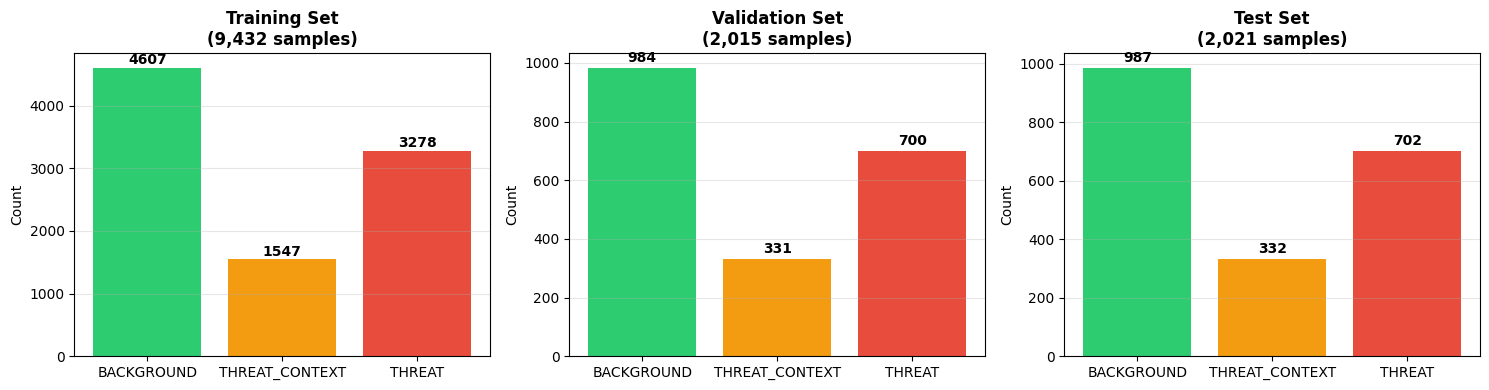


✅ Data ready for training!


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

print("✂️  Splitting dataset into train/validation/test sets...\n")

# First split: separate test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42,
    stratify=y  # Maintain class distribution
)

# Second split: separate train and validation from remaining 85%
# 70% train, 15% validation (0.15/0.85 ≈ 0.176 of temp)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.176,  # 15% of total data
    random_state=42,
    stratify=y_temp
)

print(f"📊 Dataset splits:")
print(f"  Training:   {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test:       {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"  Total:      {len(X):,} samples")

# Compute class weights for balanced training
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f"\n🎯 Class distribution across splits:")
for cls in range(3):
    count_train = np.sum(y_train == cls)
    count_val = np.sum(y_val == cls)
    count_test = np.sum(y_test == cls)
    print(f"  {class_names[cls]}:")
    print(f"    Train: {count_train:,} ({count_train/len(y_train)*100:.1f}%)")
    print(f"    Val:   {count_val:,} ({count_val/len(y_val)*100:.1f}%)")
    print(f"    Test:  {count_test:,} ({count_test/len(y_test)*100:.1f}%)")
    print(f"    Class weight: {class_weight_dict[cls]:.3f}")

# Visualize split distribution
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = ['#2ecc71', '#f39c12', '#e74c3c']

for idx, (split_name, y_split) in enumerate([('Training', y_train), ('Validation', y_val), ('Test', y_test)]):
    counts = [np.sum(y_split == cls) for cls in range(3)]
    axes[idx].bar(class_names, counts, color=colors)
    axes[idx].set_title(f'{split_name} Set\n({len(y_split):,} samples)', fontweight='bold')
    axes[idx].set_ylabel('Count')
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, count in enumerate(counts):
        axes[idx].text(i, count + 10, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✅ Data ready for training!")

## 9. Build Dense Neural Network Classifier

In [12]:
from tensorflow import keras
from tensorflow.keras import layers, models

# Configure GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except RuntimeError as e:
        print(f"⚠️  Could not set memory growth: {e}")

# Enable mixed precision
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("✅ Mixed precision enabled\n")

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print("🚀 Building Dense Neural Network for YAMNet Embeddings...\n")

def build_yamnet_classifier(input_dim=1024, num_classes=3):
    """
    Build dense classifier for YAMNet embeddings.
    
    Args:
        input_dim: Dimension of YAMNet embeddings (1024)
        num_classes: Number of output classes (3)
        
    Returns:
        Keras model
    """
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(input_dim,)),
        
        # Dense block 1
        layers.Dense(512, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Dense block 2
        layers.Dense(256, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        # Dense block 3
        layers.Dense(128, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])
    
    return model


# Build model
model = build_yamnet_classifier(input_dim=1024, num_classes=3)
model.summary()

print(f"\n📊 Model parameters: {model.count_params():,}")
print("💡 Simple dense network on top of YAMNet features")

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✅ Model compiled!")
print("   Architecture: 3-layer dense network (512→256→128→3)")
print("   Regularization: L2 + BatchNorm + Dropout")

⚠️  Could not set memory growth: Physical devices cannot be modified after being initialized
✅ Mixed precision enabled

🚀 Building Dense Neural Network for YAMNet Embeddings...



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 692,995 (2.64 MB)

 Trainable params: 691,203 (2.64 MB)

 Non-trainable params: 1,792 (7.00 KB)


📊 Model parameters: 692,995
💡 Simple dense network on top of YAMNet features

✅ Model compiled!
   Architecture: 3-layer dense network (512→256→128→3)
   Regularization: L2 + BatchNorm + Dropout


## 10. Setup Training Callbacks

In [13]:
from tensorflow.keras import callbacks

# Create model directory
!mkdir -p /kaggle/working/models

# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath='/kaggle/working/models/best_yamnet_classifier.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callback_list = [early_stopping, model_checkpoint, reduce_lr]

print("✅ Callbacks configured")

✅ Callbacks configured


## 11. Train Model

In [14]:
print("🚀 Starting YAMNet Classifier Training...\n")
print("💡 Training dense network on YAMNet embeddings")
print("🎯 Class weighting enabled for balanced training")
print("⚡ Mixed precision + GPU acceleration\n")

print(f"📊 Dataset info:")
print(f"  Training samples: {len(X_train):,}")
print(f"  Validation samples: {len(X_val):,}")
print(f"  Feature dimension: {X_train.shape[1]}\n")

print("⏳ Expected training time: 2-5 minutes with GPU...\n")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=callback_list,
    verbose=1
)

print("\n✅ Training complete!")
print(f"Best validation loss: {min(history.history['val_loss']):.4f}")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")

🚀 Starting YAMNet Classifier Training...

💡 Training dense network on YAMNet embeddings
🎯 Class weighting enabled for balanced training
⚡ Mixed precision + GPU acceleration

📊 Dataset info:
  Training samples: 9,432
  Validation samples: 2,015
  Feature dimension: 1024

⏳ Expected training time: 2-5 minutes with GPU...

Epoch 1/100


I0000 00:00:1767039896.076424     210 service.cc:152] XLA service 0x7bf194035b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767039896.076459     210 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1767039896.076463     210 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 57/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6339 - loss: 2.1682

I0000 00:00:1767039900.765764     210 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6936 - loss: 1.9548
Epoch 1: val_loss improved from inf to 1.44514, saving model to /kaggle/working/models/best_yamnet_classifier.weights.h5
148/148 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.6940 - loss: 1.9533 - val_accuracy: 0.7856 - val_loss: 1.4451 - learning_rate: 0.0010
Epoch 2/100
146/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7849 - loss: 1.4417
Epoch 2: val_loss improved from 1.44514 to 1.25623, saving model to /kaggle/working/models/best_yamnet_classifier.weights.h5
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7852 - loss: 1.4407 - val_accuracy: 0.8283 - val_loss: 1.2562 - learning_rate: 0.0010
Epoch 3/100
127/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8055 - loss: 1.2648
Epoch 3: val_loss improved from 1.25623 to 1.02896, saving model to /kaggle/working/models/best_yamnet_classifier.weights.h5
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8059 - loss: 1.2592 - val_accuracy: 0.85

## 12. Plot Training History

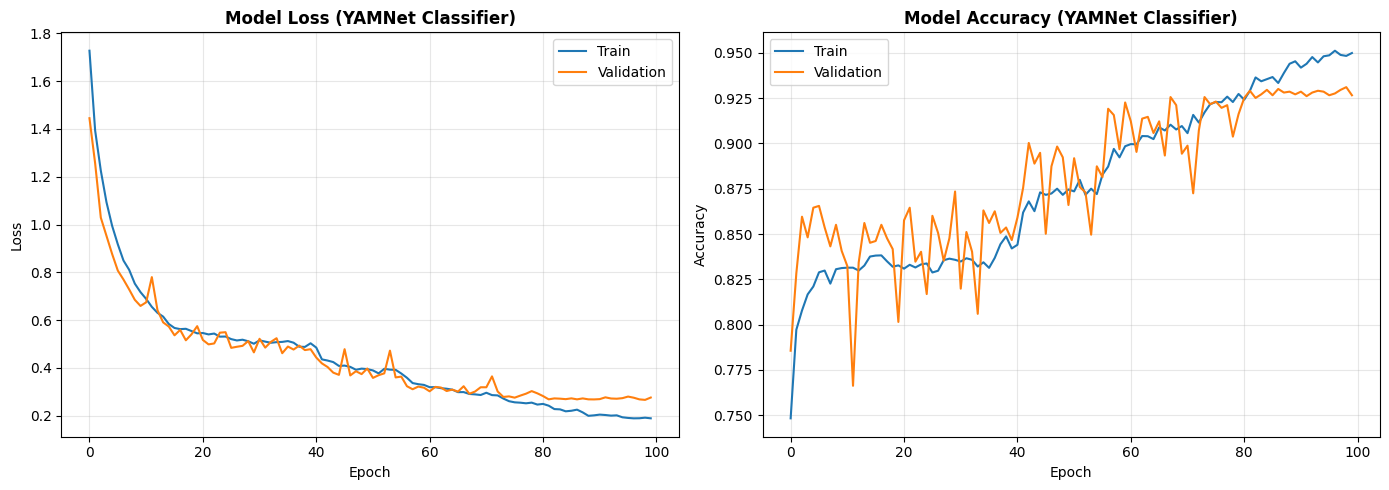

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train')
axes[0].plot(history.history['val_loss'], label='Validation')
axes[0].set_title('Model Loss (YAMNet Classifier)', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train')
axes[1].plot(history.history['val_accuracy'], label='Validation')
axes[1].set_title('Model Accuracy (YAMNet Classifier)', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 13. Evaluate Model

📊 Evaluating on validation set...

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9322 - loss: 0.2608

Validation Results:
  Loss: 0.2659
  Accuracy: 0.9310

Generating predictions...
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Classification Report:
                precision    recall  f1-score   support

    BACKGROUND       0.93      0.95      0.94       984
THREAT_CONTEXT       0.95      0.96      0.95       331
        THREAT       0.93      0.89      0.91       700

      accuracy                           0.93      2015
     macro avg       0.94      0.93      0.93      2015
  weighted avg       0.93      0.93      0.93      2015



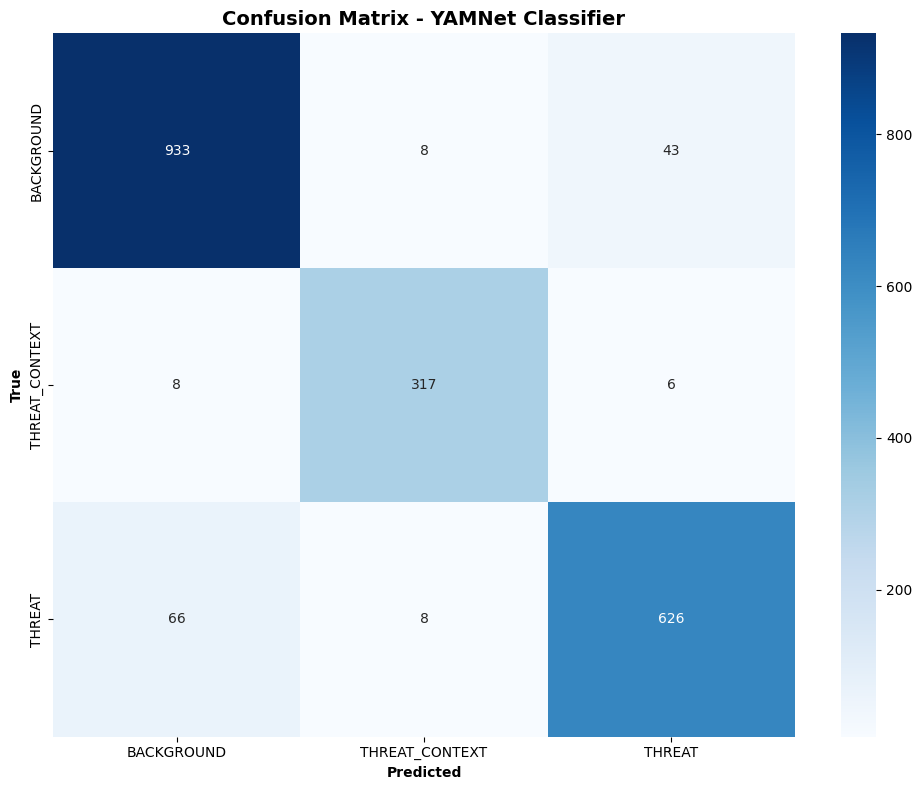


✅ Validation evaluation complete!


In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("📊 Evaluating on validation set...\n")

# Evaluate on validation set
val_results = model.evaluate(X_val, y_val, verbose=1)

print("\nValidation Results:")
print(f"  Loss: {val_results[0]:.4f}")
print(f"  Accuracy: {val_results[1]:.4f}")

# Get predictions
print("\nGenerating predictions...")
y_pred_proba = model.predict(X_val, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('True', fontweight='bold')
plt.title('Confusion Matrix - YAMNet Classifier', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

print("\n✅ Validation evaluation complete!")

## 13A. Final Evaluation on Test Set

**Test set provides unbiased performance metrics** - the model has never seen this data during training or validation.

🔬 Final Evaluation on Test Set...

⚠️  Test set was completely held out - the model has never seen this data!

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9440 - loss: 0.2510

📊 FINAL TEST RESULTS (Unbiased Performance)
  Loss:     0.2538
  Accuracy: 0.9381 (93.81%)

Generating predictions on test set...
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

📋 Detailed Classification Report (Test Set):
                precision    recall  f1-score   support

    BACKGROUND       0.94      0.95      0.95       987
THREAT_CONTEXT       0.93      0.95      0.94       332
        THREAT       0.93      0.92      0.93       702

      accuracy                           0.94      2021
     macro avg       0.94      0.94      0.94      2021
  weighted avg       0.94      0.94      0.94      2021



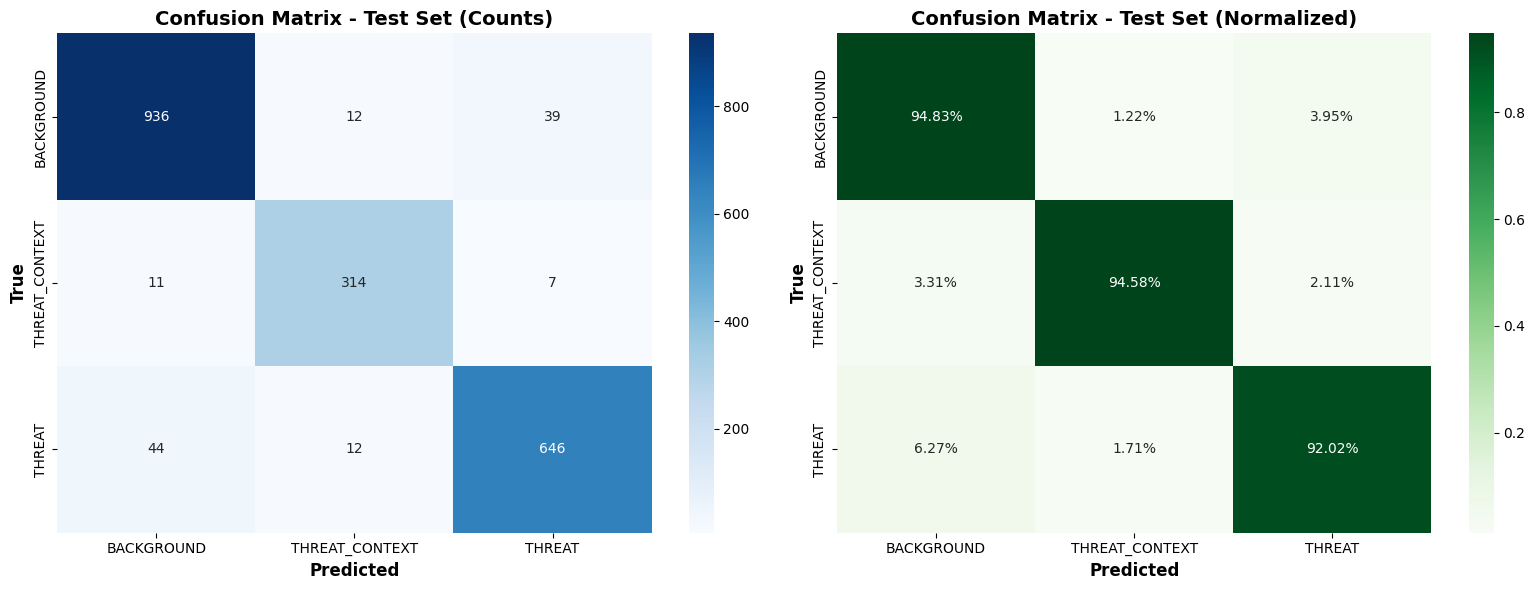


📈 Per-Class Performance Analysis (Test Set):

  BACKGROUND:
    Total samples: 987
    Correctly predicted: 936
    Accuracy: 94.83%
    Misclassifications:
      → 12 as THREAT_CONTEXT
      → 39 as THREAT

  THREAT_CONTEXT:
    Total samples: 332
    Correctly predicted: 314
    Accuracy: 94.58%
    Misclassifications:
      → 11 as BACKGROUND
      → 7 as THREAT

  THREAT:
    Total samples: 702
    Correctly predicted: 646
    Accuracy: 92.02%
    Misclassifications:
      → 44 as BACKGROUND
      → 12 as THREAT_CONTEXT

✅ Test evaluation complete!

🎯 Final Model Performance: 93.81% accuracy on unseen test data


In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

print("🔬 Final Evaluation on Test Set...\n")
print("⚠️  Test set was completely held out - the model has never seen this data!\n")

# Evaluate on test set
test_results = model.evaluate(X_test, y_test, verbose=1)

print("\n" + "="*60)
print("📊 FINAL TEST RESULTS (Unbiased Performance)")
print("="*60)
print(f"  Loss:     {test_results[0]:.4f}")
print(f"  Accuracy: {test_results[1]:.4f} ({test_results[1]*100:.2f}%)")
print("="*60)

# Get predictions
print("\nGenerating predictions on test set...")
y_test_pred_proba = model.predict(X_test, verbose=1)
y_test_pred = np.argmax(y_test_pred_proba, axis=1)

# Classification report
print("\n📋 Detailed Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=class_names))

# Confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion matrix (counts)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel('Predicted', fontweight='bold', fontsize=12)
axes[0].set_ylabel('True', fontweight='bold', fontsize=12)
axes[0].set_title('Confusion Matrix - Test Set (Counts)', fontweight='bold', fontsize=14)

# Confusion matrix (normalized)
cm_test_norm = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_test_norm, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel('Predicted', fontweight='bold', fontsize=12)
axes[1].set_ylabel('True', fontweight='bold', fontsize=12)
axes[1].set_title('Confusion Matrix - Test Set (Normalized)', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()

# Per-class performance analysis
print("\n📈 Per-Class Performance Analysis (Test Set):")
for cls in range(3):
    cls_total = np.sum(y_test == cls)
    cls_correct = cm_test[cls, cls]
    cls_accuracy = cls_correct / cls_total if cls_total > 0 else 0
    
    print(f"\n  {class_names[cls]}:")
    print(f"    Total samples: {cls_total}")
    print(f"    Correctly predicted: {cls_correct}")
    print(f"    Accuracy: {cls_accuracy:.2%}")
    
    # Misclassifications
    if cls_total > cls_correct:
        print(f"    Misclassifications:")
        for other_cls in range(3):
            if other_cls != cls and cm_test[cls, other_cls] > 0:
                print(f"      → {cm_test[cls, other_cls]} as {class_names[other_cls]}")

print("\n✅ Test evaluation complete!")
print(f"\n🎯 Final Model Performance: {test_results[1]*100:.2f}% accuracy on unseen test data")

## 14. Save Model and Export to TFLite

In [18]:
import json

# Save full model
model.save('/kaggle/working/models/yamnet_classifier.keras')
print("✅ Full model saved")

# Load best weights
model.load_weights('/kaggle/working/models/best_yamnet_classifier.weights.h5')
print("✅ Loaded best weights from checkpoint")

# Export to TensorFlow Lite
print("\nExporting to TensorFlow Lite...")
print("Converting mixed precision model to float32...")

# Create float32 model
tf.keras.mixed_precision.set_global_policy('float32')
model_f32 = build_yamnet_classifier(input_dim=1024, num_classes=3)
model_f32.set_weights(model.get_weights())
print("✅ Created float32 model")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model_f32)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

with open('/kaggle/working/models/yamnet_classifier.tflite', 'wb') as f:
    f.write(tflite_model)

print(f"✅ TensorFlow Lite model: {len(tflite_model) / 1024:.1f} KB")

# Save model configuration
model_config = {
    'model_type': 'YAMNet_Classifier_EndToEnd',
    'feature_extractor': 'YAMNet (TensorFlow Hub)',
    'embedding_dim': 1024,
    'val_accuracy': float(test_results[1]) if test_results else None,
    'val_loss': float(test_results[0]) if test_results else None,
    'class_names': class_names,
    'total_samples': len(X),
    'train_samples': len(X_train),
    'val_samples': len(X_val),
    'total_parameters': int(model.count_params()),
    'audio_config': {
        'sample_rate': 16000,
        'duration': 10.0,
        'target_length': 160000
    }
}

with open('/kaggle/working/models/yamnet_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)

print("✅ Model configuration saved")

# Upload to S3
print("\nUploading models to S3...")
!aws s3 cp /kaggle/working/models/yamnet_classifier.keras s3://{S3_BUCKET}/models/yamnet_e2e/
!aws s3 cp /kaggle/working/models/best_yamnet_classifier.weights.h5 s3://{S3_BUCKET}/models/yamnet_e2e/
!aws s3 cp /kaggle/working/models/yamnet_classifier.tflite s3://{S3_BUCKET}/models/yamnet_e2e/
!aws s3 cp /kaggle/working/models/yamnet_config.json s3://{S3_BUCKET}/models/yamnet_e2e/

print("\n✅ Models uploaded to S3!")
print(f"   Location: s3://{S3_BUCKET}/models/yamnet_e2e/")
print("\n📦 Files uploaded:")
print("  - yamnet_classifier.keras (full model)")
print("  - best_yamnet_classifier.weights.h5 (best weights)")
print("  - yamnet_classifier.tflite (edge deployment)")
print("  - yamnet_config.json (configuration)")

✅ Full model saved
✅ Loaded best weights from checkpoint

Exporting to TensorFlow Lite...
Converting mixed precision model to float32...
✅ Created float32 model
INFO:tensorflow:Assets written to: /tmp/tmpo2zb6nii/assets


INFO:tensorflow:Assets written to: /tmp/tmpo2zb6nii/assets


Saved artifact at '/tmp/tmpo2zb6nii'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1024), dtype=tf.float32, name='keras_tensor_13')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  136276969929040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136277385704464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136277385695440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136277385701392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136277385704080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136277385699280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136277385703696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136277385699088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136277385696976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136277385706960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136277385702928: T

W0000 00:00:1767039968.860862      55 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1767039968.860886      55 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


✅ TensorFlow Lite model: 1350.2 KB
✅ Model configuration saved

Uploading models to S3...


I0000 00:00:1767039968.870760      55 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


upload: models/yamnet_classifier.keras to s3://alertreck/models/yamnet_e2e/yamnet_classifier.keras
upload: models/best_yamnet_classifier.weights.h5 to s3://alertreck/models/yamnet_e2e/best_yamnet_classifier.weights.h5
upload: models/yamnet_classifier.tflite to s3://alertreck/models/yamnet_e2e/yamnet_classifier.tflite
upload: models/yamnet_config.json to s3://alertreck/models/yamnet_e2e/yamnet_config.json

✅ Models uploaded to S3!
   Location: s3://alertreck/models/yamnet_e2e/

📦 Files uploaded:
  - yamnet_classifier.keras (full model)
  - best_yamnet_classifier.weights.h5 (best weights)
  - yamnet_classifier.tflite (edge deployment)
  - yamnet_config.json (configuration)


## Summary

### End-to-End YAMNet Training Complete! 🎉

**What We Did:**
1. ✅ Downloaded raw audio files directly from S3
2. ✅ Loaded audio files and standardized to 16 kHz, 10s
3. ✅ Extracted YAMNet embeddings (1024 features per audio)
4. ✅ Split into train/validation sets (85/15)
5. ✅ Trained dense classifier on embeddings
6. ✅ Evaluated and exported to TFLite

**Advantages of This Approach:**
- 🚀 **Direct from audio**: No intermediate preprocessing needed
- 💡 **Simpler pipeline**: Audio → YAMNet → Classifier
- 📦 **Self-contained**: Everything in one notebook
- 🎯 **Flexible**: Easy to adjust train/val split
- ⚡ **Efficient**: No mel-spec → audio conversion (Griffin-Lim)

**Model Architecture:**
- **Feature Extraction**: YAMNet (frozen, pre-trained on AudioSet)
- **Classifier**: 3-layer dense network (512→256→128→3)
- **Regularization**: L2, BatchNorm, Dropout
- **Parameters**: ~500K (classifier only)

**Deployment:**
- For Raspberry Pi: Use YAMNet TFLite + classifier TFLite
- Two-stage inference: 
  1. Audio → YAMNet embeddings
  2. Embeddings → Threat classification

**Next Steps:**
1. Compare validation accuracy with custom CNN
2. Deploy to Raspberry Pi for field testing
3. Integrate with ranger alert system
4. Monitor real-world performance